<a href="https://colab.research.google.com/github/rachelash/fastai/blob/master/WritingClassification_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from fastai.vision import *
from fastai.metrics import error_rate

bs = 16

path_anno = path/'annotations'
path_img = path/'images'

fnames = get_image_files(path_img)
fnames[:5]

# tfms = get_transforms(do_flip=False)
# data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

data.show_batch(rows=3, figsize=(7,6))

print(data.classes)

learn = cnn_learner(data, models.resnet34, metrics=error_rate)

# learn = cnn_learner(data, models.resnet18, metrics=accuracy)
# learn.fit(2)

learn.lr_find()

learn.fit_one_cycle(4)

learn.save('stage-1')



In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_top_losses(9, figsize=(15,11))

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

interp.most_confused(min_val=2)

In [0]:
learn.unfreeze()
learn.load('stage-1');
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))
learn.lr_find()
learn.recorder.plot()
learn.fit_one_cycle(8)


In [0]:
df = pd.read_csv(path/'labels.csv')
df.head()

data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes


In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

In [0]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)


In [0]:
# urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
# window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

# download from google

#dest.mkdir(parents=True, exist_ok=True)

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from fastai.vision import *

dest = Path('/content/gdrive/My Drive/Writing/TypedFiles')
path = '/content/gdrive/My Drive/Writing'

# folder = 'TypedFiles'
# file = 'TypedFiles.csv'

folder = 'HandWriting'
file = 'HandWriting.csv'

download_images(os.path.join(path,file), os.path.join(path,folder), max_pics=200)

In [0]:
path = '/content/gdrive/My Drive/Writing/'
classes = ['TypedFiles','HandWriting']

In [0]:
for c in classes:
    print(c)
    class_path = os.path.join('/content/gdrive/My Drive/Writing/', c)
    verify_images(class_path, delete=True, max_size=500)

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

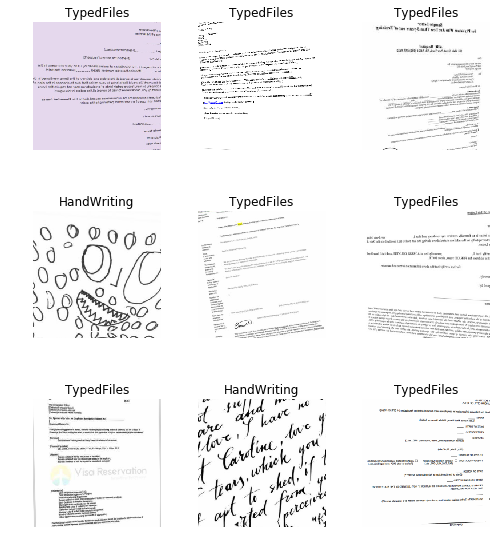

In [9]:
data.show_batch(rows=3, figsize=(7,8))

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 17624792.88it/s]


In [11]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.524308,0.291502,0.081081,01:47
1,0.307354,0.090283,0.027027,01:48
2,0.206069,0.038028,0.013514,01:48
3,0.153632,0.021354,0.013514,01:48


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


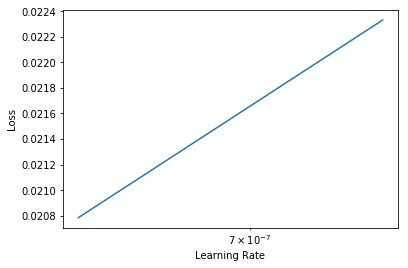

In [17]:
learn.recorder.plot()

In [0]:
#If the plot is not showing try to give a start and end learning rate# learn.
#lr_find(start_lr=1e-5, end_lr=1e-1)learn.recorder.plot()


In [18]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.042549,0.010176,0.000000,02:30
1,0.028878,0.004717,0.000000,02:29


In [0]:
learn.save('stage-2')

In [0]:
learn.load('stage-2');

In [0]:
#learn.recorder.plot_losses()

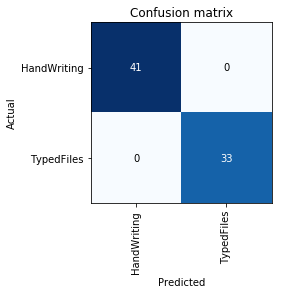

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the ImageCleaner widget from fastai.widgets we can prune our top losses, removing photos that don't belong.

In [0]:
from fastai.widgets import *

db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

# changing ds and load the same model
learn_cln.load('stage-2');

ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [0]:
#export the content of our Learner object for production:
learn.export()

#This will create a file named 'export.pkl' in the directory where we were working that contains 
#everything we need to deploy our model (the model, the weights but also some metadata like the classes 
#or the transforms/normalization used).

#and for testing the model on cpu:

defaults.device = torch.device('cpu')

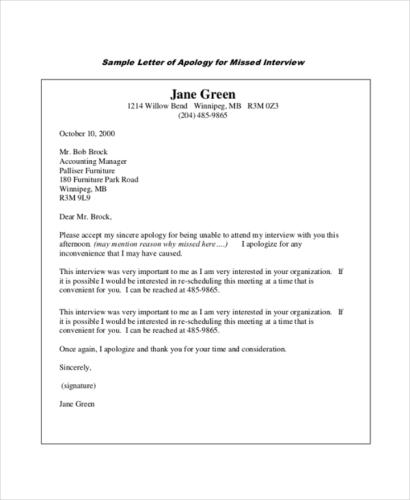

In [32]:
img = open_image(os.path.join(path,classes[0],'00000001.jpg'))
img

In [0]:
learn = load_learner('/content/gdrive/My Drive/Writing')

In [33]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category TypedFiles